<a href="https://colab.research.google.com/github/xeqoir/Data-Science/blob/main/Unit4/YaleXie_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [2]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)
diff_TminusE = cs_data.theo - cs_data.exp
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)
cs_data

,ID,aa,theo,exp,diff_TminusE,cat
0,1BM8,ILE,61.18,58.27,2.91,Non-Polar
1,1BM8,TYR,56.95,56.18,0.77,Polar
2,1BM8,SER,56.35,56.84,-0.49,Polar
3,1BM8,ALA,51.96,51.01,0.95,Special
4,1BM8,ARG,56.54,54.64,1.90,Charged
...,...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,-1.72,Charged
1772,1KS9,ARG,58.91,59.02,-0.11,Charged
1773,1KS9,LYS,59.49,58.92,0.57,Charged
1774,1KS9,GLU,59.48,58.36,1.12,Charged


In [3]:
aa_encode = pd.Categorical(cs_data['aa'])
aa_encode
aa_idx = aa_encode.codes
aa_idx
aa_coords = {"aa": aa_encode.categories}
aa_coords

{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

In [4]:
with pm.Model(coords=aa_coords) as cs_h_model: # StudentT priors and likelihood
    μ_mu = pm.StudentT('μ_mu', mu = 0, sigma = 10, nu = 30)
    μ_sd = pm.HalfStudentT('μ_sd', sigma = 10, nu = 30)
    μ_nm = pm.HalfStudentT('μ_nm', sigma = 10, nu = 30)

    μ = pm.StudentT('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  nu = μ_nm,
                  dims = "aa")

    σ = pm.HalfStudentT('σ',
                        sigma = 10,
                        nu = 30,
                        dims = "aa")
    ν = pm.HalfStudentT('ν',
                        sigma = 10,
                        nu = 30,
                        dims = "aa")

    y = pm.StudentT('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  nu = ν[aa_idx],
                  observed = cs_data.diff_TminusE)

    idata_cs_h = pm.sample()

Output()

Output()

In [5]:
with pm.Model(coords=aa_coords) as cs_h_model2: # Normal priors and likelihoods
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    idata_cs_h2 = pm.sample()

Output()

Output()

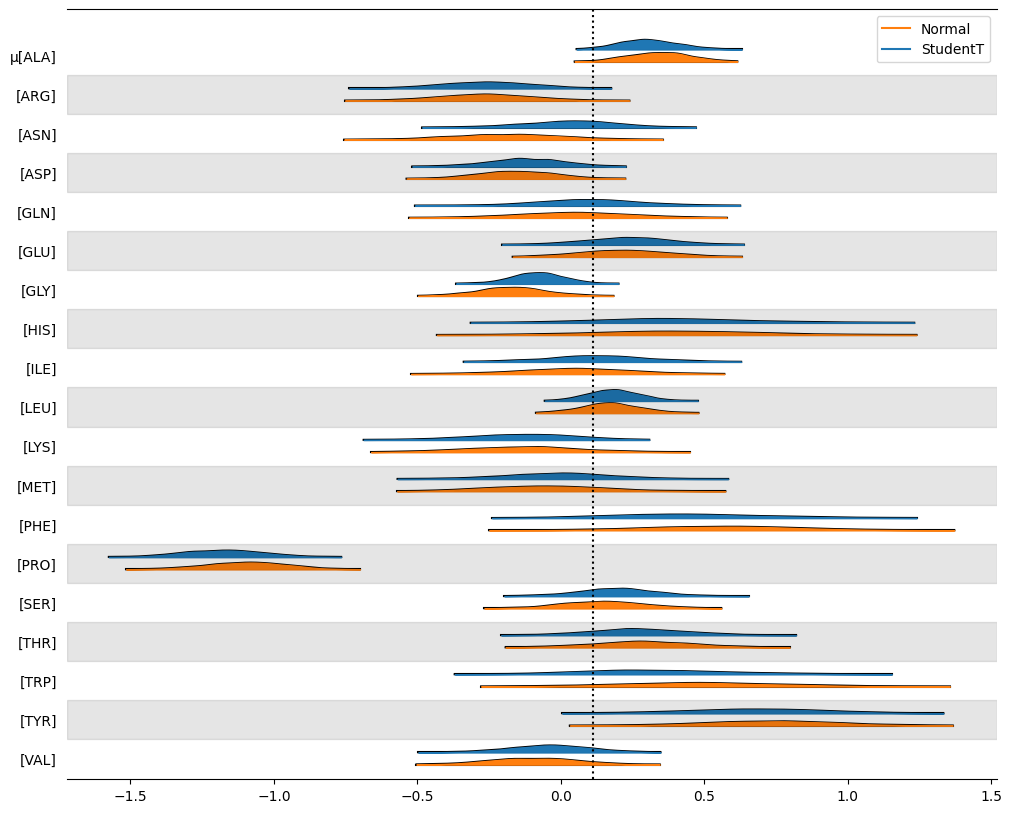

In [6]:
axes = az.plot_forest([idata_cs_h, idata_cs_h2], kind="ridgeplot",
                      model_names=['StudentT', 'Normal'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

#plots overall mean of the hierarchical model; do not confuse with 0
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

The StudentT one is much closer to the mean for most of the amino acids.

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Output()

(-15.0, 15.0)

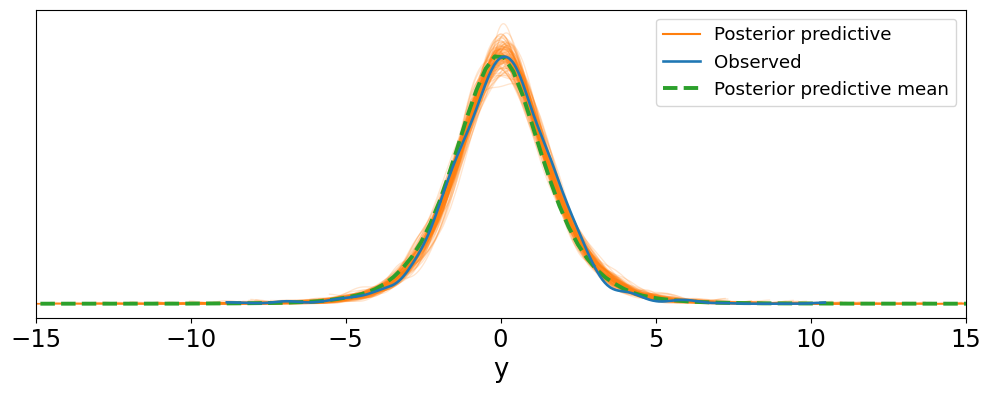

In [7]:
pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model, extend_inferencedata=True)
ax = az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C2"])
ax.set_xlim(-15,15)

# Posterior predictive check for StudentT priors and likelihood

Output()

(-15.0, 15.0)

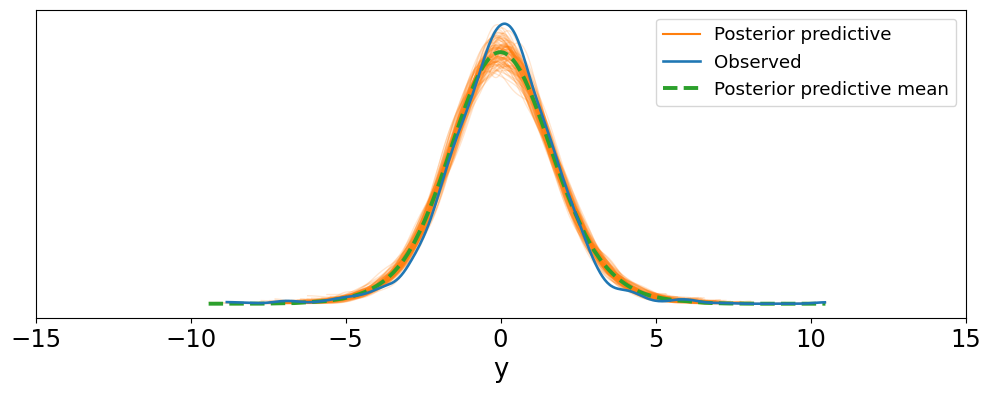

In [8]:
pm.sample_posterior_predictive(idata_cs_h2, model=cs_h_model2, extend_inferencedata=True)
ax = az.plot_ppc(idata_cs_h2, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C2"])
ax.set_xlim(-15,15)
# Posterior predictive check for Normal priors and likelihood

The **StudentT** model fits much better to the observed, particularly at the **top of the distribution**, where the Normal model is clearly below the observed. The StudentT model also fits the sides just a bit better than the Normal model, indicating a more accurate standard deviation and kurtosis.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [27]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})
sccr_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [28]:
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [29]:
with pm.Model(coords = sccr_coords) as sccr_model_nh:

    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = 1/11, nu = 55, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_nh = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.002 1.002 1.0 1.0 ... 1.0 0.9995 1.008
    μ_p      (pos) float64 32B 1.003 1.0 1.039 1.001
    ν_p      (pos) float64 32B 1.015 1.008 1.232 1.015

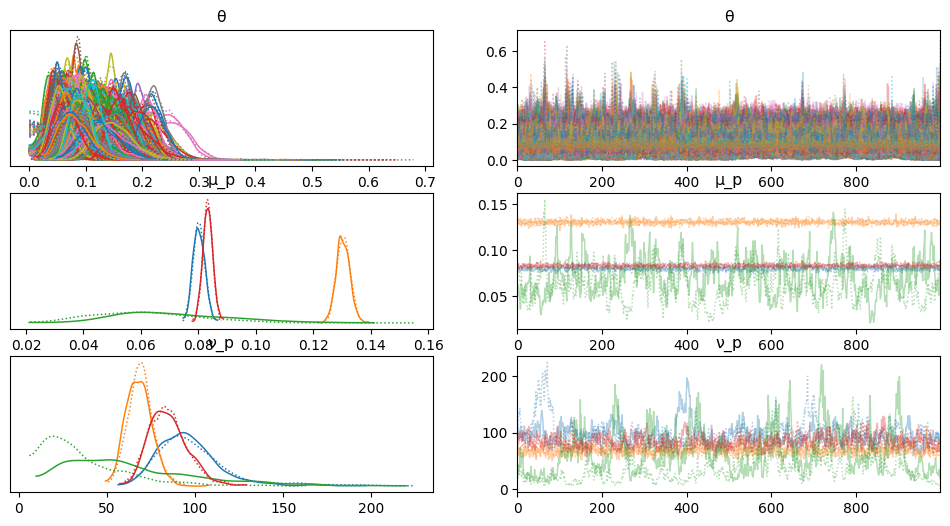

In [30]:
az.plot_trace(idata_sccr_nh)
az.rhat(idata_sccr_nh)

The nonhierarchical R hat values are generally **further from 1** than the hierarchical R hat values (for μ_p, ν_p, and θ, the ones they share). This is particularly evident for **ν_p** R hat values, where the nonhierarchical model reached 1.232, while the hierarchical model is closer at 1.172. However, the **θ and μ_p** R hat values were remarkably **close** between the hierarchical and nonhierarchical models; both had θ values within 0.005 of 1 and μ_p values within 0.05 of 1. I also found it a bit interesting that the θ R hat values were the only ones that dipped **below** 1.

As for the traces, θ was **very similar** between hierarchical and nonhierarchical, as both stretched no higher than 0.75. However, the nonhierarchical one had perhaps a **few more outliers** in amplitude than the hierarchical one. For μ_p and ν_p, the nonhierarchical model looks like it has more outliers, and the values go higher than the hierarchical model. For example, the ν_p for the hierarchical model only reaches a little above 200 in a few places while the ν_p for the nonhierarchical model reaches above 300 in some places. However, the μ_p and ν_p traces **overall** were relatively similar.



**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

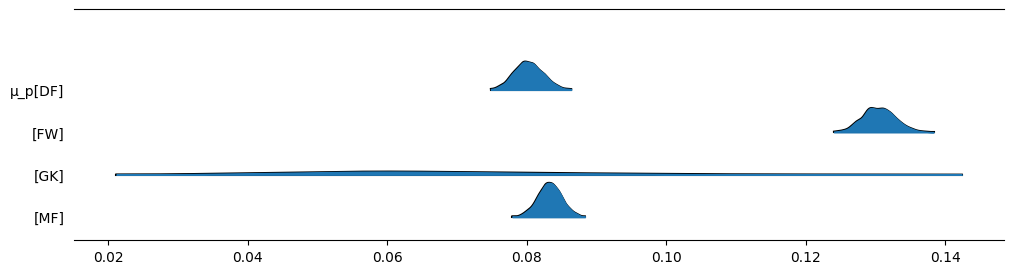

In [31]:
az.plot_forest(idata_sccr_nh, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

The posteriors of the hierarchical and nonhierarchical model are pretty **similar**. For the non-goalkeeper positions, **the peaks and widths of the curves are practically identical** (DF and MF might be very slightly higher for the nonhierarchical model I created). As for the odd goalkeeper position, the posteriors for both the hierarchical and nonhierarchical model seem to be perplexed by it. One difference, which I'm not completely sure is significant, is that the hierarchical model's x-values end at 0.175 and the nonhierarchical model's x-values end at 0.200.

**Note to self after talking to Mr. Arredondo:** The difference in range *is* significant: it's due to the shrinkage hierarchical models get (nonhierarchical models do not have shrinkage, I think). This shrinkage results in less variance, which is observed with a decreased range.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [23]:
sccr_data_new = pd.read_csv(url_sccr)
sccr_data_new = sccr_data_new.query('position != "GK"')
sccr_data_new['position'] = sccr_data_new['position'].astype('category')
sccr_data_new

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [24]:
pos_idx_new = sccr_data_new.position.cat.codes.values

#an array of the four strings that represent position
pos_codes_new = sccr_data_new.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords_new = {"pos": pos_codes_new}

In [25]:
with pm.Model(coords = sccr_coords_new) as sccr_model_h: # hierarchical without goalkeepers
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx_new], nu = ν_p[pos_idx_new])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data_new.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data_new.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_h = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 3)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.001 1.005 0.9999 ... 0.9995 1.0 1.001
    μ        float64 8B 1.002
    μ_p      (pos) float64 24B 1.008 1.0 1.003
    ν        float64 8B 0.9994
    ν_p      (pos) float64 24B 1.013 1.005 1.039

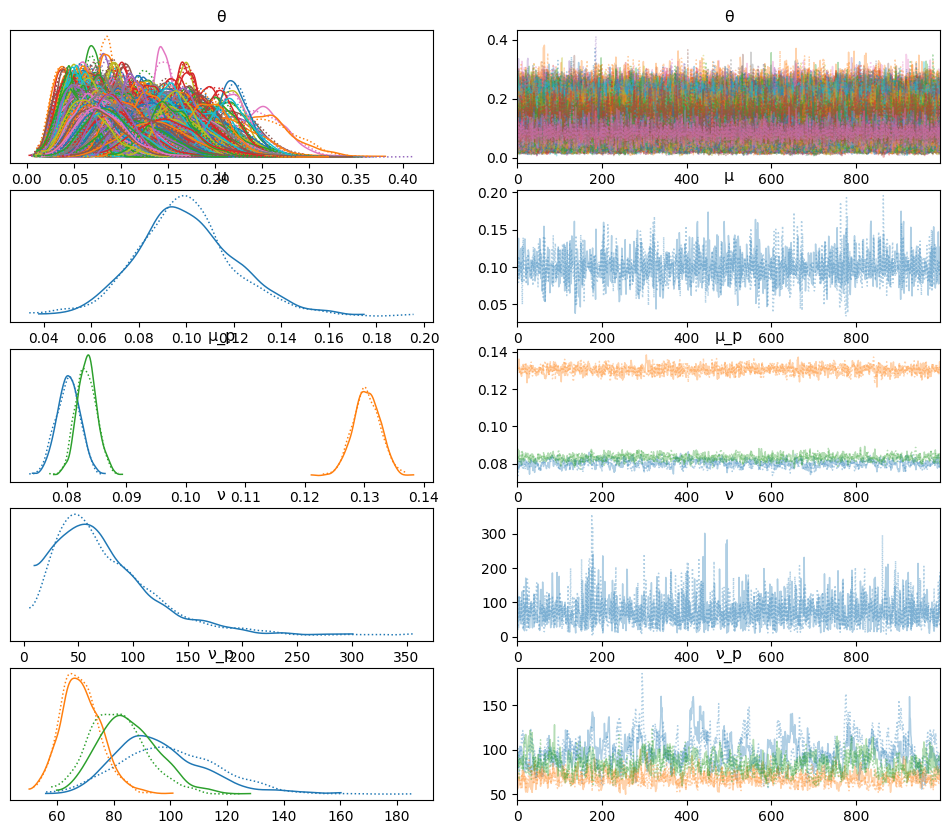

In [26]:
az.plot_trace(idata_sccr_h)
az.rhat(idata_sccr_h)

The hierarchical model without goalkeeper stats was much easier for pymc to process (the hierarchical model with goalkeeper stats took 8 minutes to execute while the hierarchical model without goalkeeper stats took only 4 minutes to execute).

By dropping goalkeeper stats, we lose some data points, but we make the overall graphs much better; the model without goalkeeper states had better R hat values (pretty much all within 0.01 of 1) and much more consistent amplitudes (which are clear to see particularly in the θ and ν_p traces).